## Exercise 4

In [85]:
import torch
from Fast_MRI_dataloader import create_dataloaders
from tqdm import tqdm 
import matplotlib.pyplot as plt
from torch.fft import fft2, fftshift, ifft2, ifftshift
import numpy as np

Load data

In [86]:
data_loc = 'Fast_MRI_Knee/' #change the datalocation to something that works for you
batch_size = 6

train_loader, test_loader = create_dataloaders(data_loc, batch_size)
for i,(kspace, M, gt) in enumerate(tqdm(test_loader)):
    if i == 1:
        break
print ("kspace shape: ", kspace.shape)
print ("M shape: ", M.shape)
print ("gt shape: ", gt.shape)

  2%|▏         | 1/41 [00:00<00:07,  5.12it/s]

kspace shape:  torch.Size([6, 320, 320])
M shape:  torch.Size([6, 320, 320])
gt shape:  torch.Size([6, 320, 320])


Exericse 4b

In [164]:
def get_k_space(MRI_image) :
    # convert MRI image into k-space
    #k_space = fftshift(fft2(MRI_image))
    k_space = fft2(MRI_image)
    return k_space

def get_partial_k_space(k_space,M) :
    # element wise multiplication of k-space and M
    return  torch.mul(k_space, M)

def get_accelerate_MRI(k_space) :
    # convert k-space to MRI image
    return ifft2(k_space)

def get_accelerate_MRI_final(input) :
    # convert k-space to MRI image
    return ifft2(ifftshift(input))

def soft_threshold(input, threshold) :
    idx = torch.abs(input) > threshold
    input[idx] = input[idx] * (torch.abs(input[idx]) - threshold)/torch.abs(input[idx])
    input[~idx] = 0
        
    return input

In [165]:
def ISTA(mu, shrinkage, K, k_space, M) :

    # get accelerated MRI image from partial k-space
    y = get_accelerate_MRI(k_space)
    #y = torch.log(torch.abs(y)+1e-20)
    
    image_list = []

    for idx, (y, M) in tqdm(enumerate(zip (y,M))):
    
        # initialize 
        x_t = y
    
        for i in range(K):

            # soft thresholding
            x_t = soft_threshold(x_t, shrinkage)
            F_x = get_k_space(x_t)
            k_space_y = get_k_space(y)
            
            z = F_x - mu * get_partial_k_space(F_x, M) + mu * k_space_y
            if i == K-1:
                x_t = get_accelerate_MRI_final(z)
            else:
                x_t = get_accelerate_MRI(z)

        # store the results
        image_list.append(x_t)

    # convert to tensor
    x_out = torch.stack(image_list,dim=0).float()

    return x_out

In [190]:
mu = 0.5
shrinkage = 0.1
K = 100

x_t = ISTA(mu, shrinkage, K, kspace, M)
x_t_friendly = torch.log(torch.abs(x_t)+1e-20)
accelerated_mri_input = get_accelerate_MRI(kspace)
k_space_x_out = fftshift(fft2(x_t))
accerated_plot_friendly = torch.log(torch.abs(accelerated_mri_input )+1e-20)
kspace_plot_friendly = torch.log(torch.abs(kspace[2,:,:])+1e-20)
k_space_x_out_plot_friendly = torch.log(torch.abs(k_space_x_out[2,:,:])+1e-20)

full_k = fftshift(fft2(gt))
full_k_friendly = torch.log(torch.abs(full_k[2,:,:])+1e-20)


6it [00:03,  1.59it/s]


Plot everything for visaulization

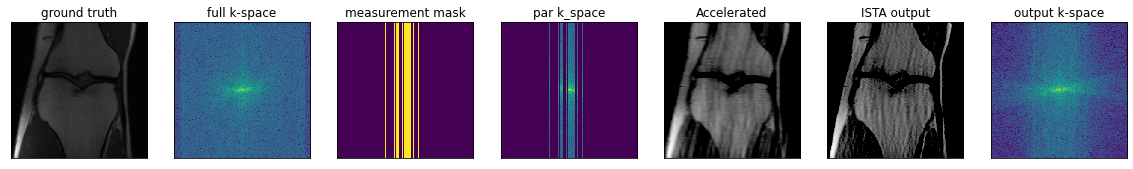

In [195]:

plt.figure(figsize = (20,20))

plt.subplot(1,7,1)
plt.imshow(gt[2,:,:],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('ground truth')

plt.subplot(1,7,2)
plt.imshow(full_k_friendly,vmin=-1.3,interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('full k-space')

plt.subplot(1,7,3)
plt.imshow(M[2,:,:],interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('measurement mask')

plt.subplot(1,7,4)
plt.imshow(kspace_plot_friendly,vmin=-1.3,interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('par k_space')

plt.subplot(1,7,5)
plt.imshow(accerated_plot_friendly[2,:,:],vmin=-1,interpolation='nearest',cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Accelerated')

plt.subplot(1,7,6)
plt.imshow(x_t_friendly[2,:,:],vmin=-1.5,interpolation='nearest',cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('ISTA output')

plt.subplot(1,7,7)
plt.imshow(k_space_x_out_plot_friendly,vmin=-1.3,interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('output k-space')

plt.show()

Exericse 4c

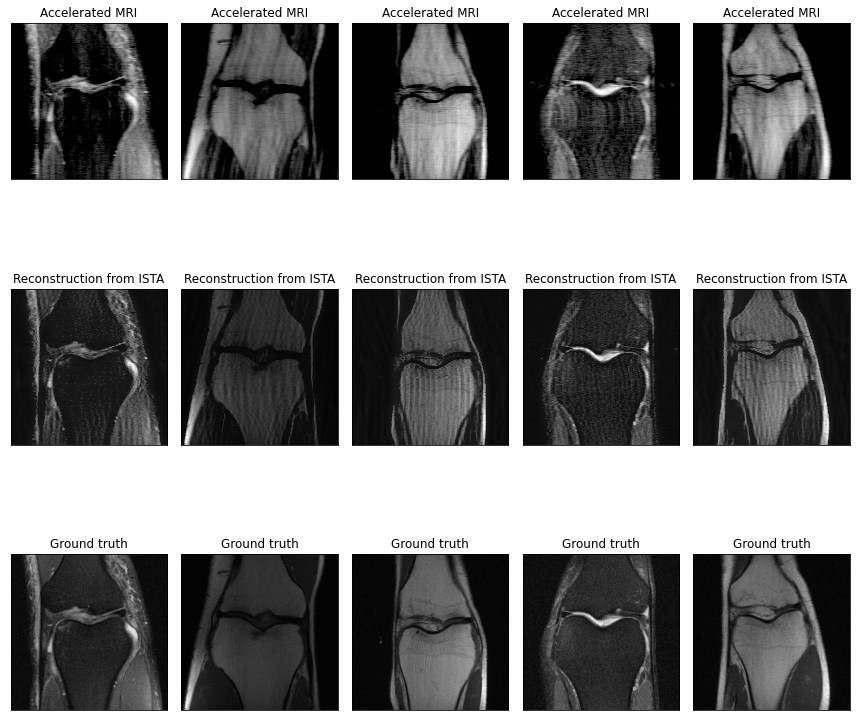

In [214]:
def plot_ex4c(test_acc_mri, test_x_out, test_gt, save_path):

    plt.figure(figsize = (12,12))
    for i in range(5):
        plt.subplot(3,5,i+1)
        plt.imshow(test_acc_mri[i+1,:,:],vmin=-1.1,interpolation='nearest',cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title('Accelerated MRI')

        plt.subplot(3,5,i+6)
        plt.imshow(test_x_out[i+1,:,:],vmin=-0.1,interpolation='nearest',cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title('Reconstruction from ISTA')

        plt.subplot(3,5,i+11)
        plt.imshow(test_gt[i+1,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title('Ground truth')

    #plt.savefig(f"{save_path}", dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

plot_ex4c(accerated_plot_friendly, x_t, gt,'figures/ex4c.png')